# **음악 스트리밍 서비스 kkbox의 고객 이탈률 예측**</br>


## **프로젝트의 필요성**</br>
> </br>
> 기업의 입장에서, 매출을 발생시키는 고객을 신규 유입시키는 데 발생하는 비용보다 기존 고객을 이탈하지 않도록 유지하는 비용이 더 낮음.
>
> 특히 음악 스트리밍과 같은 구독형 비즈니스 모델을 가진 서비스의 경우 기존 고객이 이탈하지 않도록 유지하는 것은 현재의 매출만이 아닌 미래의 현금 흐름 창출에도 중요한 요소로 작용.
> 
> 또한 고객의 이탈 데이터를 분석하여 현재 서비스 개선에 대한 의사결정의 근거를 마련할 수 있음.</br>
> </br>

## **목표**</br>
> </br>
> - 1차 : 머신 러닝을 통한 고객 전환 예측</br></br>
> - 2차 : 대쉬보드 생성</br></br>
> - 3차 : Slack을 통해 이탈 가능성이 높은 고객의 정보를 자동으로 전달할 수 있도록 시스템 구축</br>
></br>

## 추가적으로 생각해볼 수 있는 features

> </br>
> 사용자의 서비스 사용 횟수(일 단위) / 사용자의 총 서비스 가입 기간</br></br>
> </br></br>
> </br>
></br> 

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import jiho_module as jm
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, datediff, sum, when, to_date, concat_ws, substring, lag, avg, count
from pyspark.sql.types import DateType
from pyspark.sql.window import Window


In [2]:
spark = SparkSession.builder.appName('predict_chrun_rate').getOrCreate()

In [13]:
train_df_v2 = spark.read.option('header', 'true').csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/train_v2.csv', inferSchema=True)
train_df = spark.read.option('header', 'true').csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/train.csv', inferSchema=True)
members_df_v3 = spark.read.option('header', 'true').csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/members_v3.csv', inferSchema=True)
transactions_df_v2 = spark.read.option('header', 'true').csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/transactions_v2.csv', inferSchema=True)
transactions_df = spark.read.option('header', 'true').csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/transactions.csv', inferSchema=True)
user_logs_df_v2 = spark.read.option('header', 'true').csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/user_logs_v2.csv', inferSchema=True)
user_logs_df = spark.read.option('header', 'true').csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/user_logs.csv', inferSchema=True)

In [75]:
train_df_merged = train_df_v2.unionAll(train_df)
train_df_merged = train_df_merged.drop_duplicates(['msno'])
transactions_df_merged = transactions_df.unionAll(transactions_df_v2)
user_logs_df_merged = user_logs_df.unionAll(user_logs_df_v2)

In [15]:
members_df_v3 = jm.int_to_date(members_df_v3, 'registration_init_time')
transactions_df_merged = jm.int_to_date(transactions_df_merged, 'transaction_date')
transactions_df_merged = jm.int_to_date(transactions_df_merged, 'membership_expire_date')
user_logs_df_merged = jm.int_to_date(user_logs_df_merged, 'date')

### train_df 살펴보기

In [21]:
train_df_merged.printSchema()

root
 |-- msno: string (nullable = true)
 |-- is_churn: integer (nullable = true)



In [118]:
train_df_merged.count(), train_df_merged.select('msno').distinct().count()

(1963891, 1082190)

In [7]:
train_df_merged = train_df_merged.drop_duplicates(['msno'])

In [8]:
train_test = train_df_merged.unionAll(test)

In [9]:
test.select('msno').count()

907471

In [10]:
test.select('msno').distinct().count()

907471

In [11]:
train_test.select('msno').distinct().count()

1143472

In [124]:
train_df_merged.count()

1082190

In [20]:
test.filter(col('msno')==1).count()

0

In [6]:
print(train_df.filter(col('is_churn') == 0).count(), 
      train_df.filter(col('is_churn') == 1).count(), 
      round(train_df.filter(col('is_churn') == 1).count()/train_df.count()*100, 2), '%')
print(train_df_v2.filter(col('is_churn') == 0).count(), 
      train_df_v2.filter(col('is_churn') == 1).count(), 
      round(train_df_v2.filter(col('is_churn') == 1).count()/train_df_v2.count()*100, 2), '%')
print(train_df_merged.filter(col('is_churn') == 0).count(), 
      train_df_merged.filter(col('is_churn') == 1).count(), 
      round(train_df_merged.filter(col('is_churn') == 1).count()/train_df_v2.count()*100, 2), '%')

929460 63471 6.39 %
883630 87330 8.99 %
947710 134480 13.85 %


In [7]:
train_df_merged_grouped = train_df_merged.groupBy('is_churn').count()

In [9]:
train_df_merged_grouped.show()

+--------+------+
|is_churn| count|
+--------+------+
|       1|134480|
|       0|947710|
+--------+------+



In [22]:
np.array(train_df_merged_grouped.select('is_churn').collect()).reshape(-1)
np.array(train_df_merged_grouped.select('count').collect()).reshape(-1)

array([1, 0])

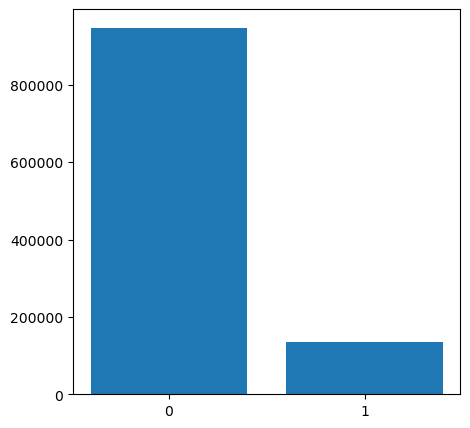

In [27]:
plt.figure(figsize=(5,5))
plt.bar(x=np.array(train_df_merged_grouped.select('is_churn').collect()).reshape(-1),
        height=np.array(train_df_merged_grouped.select('count').collect()).reshape(-1))
plt.xticks([0,1])
plt.show()

In [45]:
print(train_df.filter(col('msno').isNull()).count())
print(train_df.filter(col('is_churn').isNull()).count())
print(train_df_v2.filter(col('msno').isNull()).count())
print(train_df_v2.filter(col('is_churn').isNull()).count())

0
0
0
0


In [48]:
print(train_df.select('msno').distinct().count())
print(train_df_v2.select('msno').distinct().count())

992931
970960


### members_df 살펴보기

- members_df는 v2가 없고 v3만 있음
- v3는 2017년 11월 13일에 업데이트가 진행되었으며, 다른 데이터의 경우 2017년 3월 31일까지의 데이터만 담고 있음

In [49]:
members_df_v3.head()

Row(msno='Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=', city=1, bd=0, gender=None, registered_via=11, registration_init_time=20110911)

In [52]:
print('msno :', members_df_v3.filter(col('msno').isNull()).count())
print('city :', members_df_v3.filter(col('city').isNull()).count())
print('bd :',members_df_v3.filter(col('bd').isNull()).count())
print('gender :',members_df_v3.filter(col('gender').isNull()).count())
print('registered_via :',members_df_v3.filter(col('registered_via').isNull()).count())
print('registration_init_time :',members_df_v3.filter(col('registration_init_time').isNull()).count())

msno : 0
city : 0
bd : 0
gender : 4429505
registered_via : 0
registration_init_time : 0


In [54]:
print('bd == 0 :',members_df_v3.filter(col('bd')==0).count())

bd == 0 : 4540215


In [60]:
print('distinct city :', members_df_v3.select('city').distinct().orderBy(col('city')).collect())

distinct city : [Row(city=1), Row(city=3), Row(city=4), Row(city=5), Row(city=6), Row(city=7), Row(city=8), Row(city=9), Row(city=10), Row(city=11), Row(city=12), Row(city=13), Row(city=14), Row(city=15), Row(city=16), Row(city=17), Row(city=18), Row(city=19), Row(city=20), Row(city=21), Row(city=22)]


In [61]:
print('distinct registered_via :', members_df_v3.select('registered_via').distinct().orderBy(col('registered_via')).collect())

distinct registered_via : [Row(registered_via=-1), Row(registered_via=1), Row(registered_via=2), Row(registered_via=3), Row(registered_via=4), Row(registered_via=5), Row(registered_via=6), Row(registered_via=7), Row(registered_via=8), Row(registered_via=9), Row(registered_via=10), Row(registered_via=11), Row(registered_via=13), Row(registered_via=14), Row(registered_via=16), Row(registered_via=17), Row(registered_via=18), Row(registered_via=19)]


In [63]:
print('registered_via == -1 :', members_df_v3.filter(col('registered_via')==-1).count())

registered_via == -1 : 1


In [37]:
members_df_v3_groupby_city = members_df_v3.groupBy("city").count().select('*').orderBy('city')
members_df_v3_groupby_bd = members_df_v3.groupBy("bd").count().select('*').orderBy('bd')
members_df_v3_groupby_registered_via = members_df_v3.groupBy("registered_via").count().select('*').orderBy('registered_via')
members_df_v3_groupby_registration_init_time = members_df_v3.groupBy("registration_init_time").count().select('*').orderBy('registration_init_time')

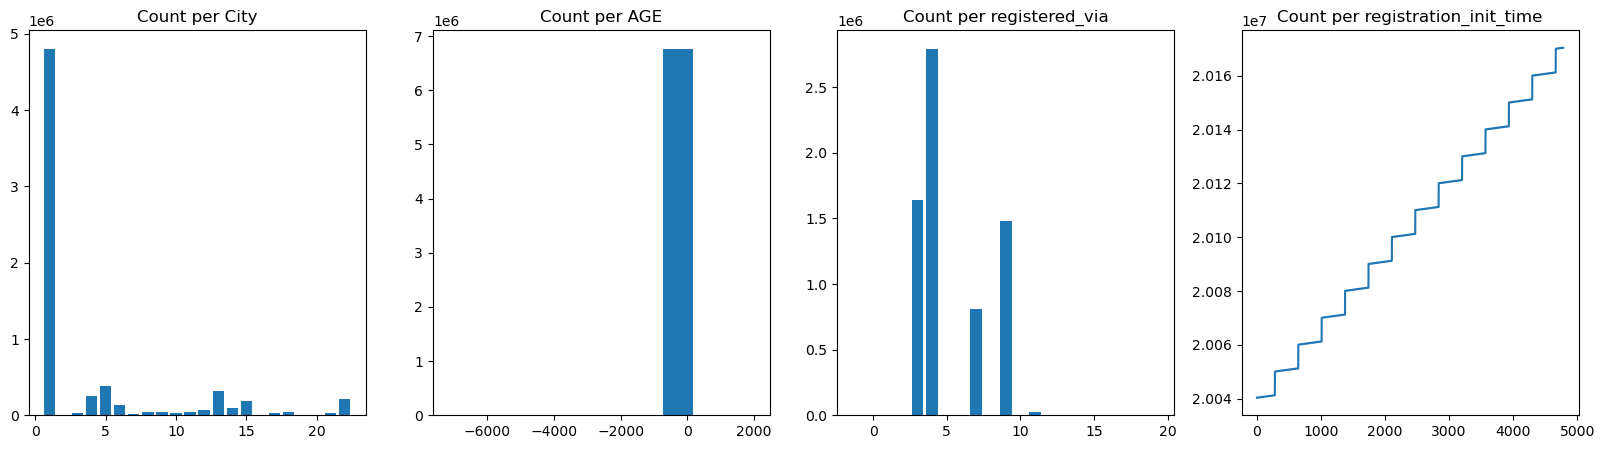

In [49]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.bar(x=np.array(members_df_v3_groupby_city.select('city').collect()).reshape(-1),
        height=np.array(members_df_v3_groupby_city.select('count').collect()).reshape(-1))
plt.title("Count per City")
plt.subplot(1,4,2)
plt.hist(x=np.array(members_df_v3.select('bd').collect()).reshape(-1))
plt.title("Count per AGE")
plt.subplot(1,4,3)
plt.bar(x=np.array(members_df_v3_groupby_registered_via.select('registered_via').collect()).reshape(-1),
        height=np.array(members_df_v3_groupby_registered_via.select('count').collect()).reshape(-1))
plt.title("Count per registered_via")
plt.subplot(1,4,4)
plt.plot(np.array(members_df_v3_groupby_registration_init_time.select('registration_init_time').collect()).reshape(-1))
plt.title("Count per registration_init_time")
plt.show()

In [73]:
print(members_df_v3.select(min('registration_init_time')).show())
print(members_df_v3.select(max('registration_init_time')).show())

+---------------------------+
|min(registration_init_time)|
+---------------------------+
|                   20040326|
+---------------------------+

None
+---------------------------+
|max(registration_init_time)|
+---------------------------+
|                   20170429|
+---------------------------+

None


### transaction_df 살펴보기

In [79]:
transactions_df_merged.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: integer (nullable = true)
 |-- membership_expire_date: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)



In [90]:
transactions_df_merged.select('msno').distinct().count()

2426143

In [111]:
transactions_df_merged.head()

Row(msno='YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=', payment_method_id=41, payment_plan_days=30, plan_list_price=129, actual_amount_paid=129, is_auto_renew=1, transaction_date=20150930, membership_expire_date=20151101, is_cancel=0)

In [107]:
transactions_df_merged.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20150101|              20171106|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20150104|              20171207|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               119|            1|        20150123|              20180107|        0|
|hqWmt5OeZ3ab3MZdX...|               41|            

In [110]:
print(
    transactions_df.select(min('transaction_date')).show(),
    transactions_df.select(max('transaction_date')).show(),
    transactions_df_v2.select(min('transaction_date')).show(),
    transactions_df_v2.select(max('transaction_date')).show()
)

+---------------------+
|min(transaction_date)|
+---------------------+
|             20150101|
+---------------------+

+---------------------+
|max(transaction_date)|
+---------------------+
|             20170228|
+---------------------+

+---------------------+
|min(transaction_date)|
+---------------------+
|             20150101|
+---------------------+

+---------------------+
|max(transaction_date)|
+---------------------+
|             20170331|
+---------------------+

None None None None


In [115]:
print(
    transactions_df.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show(),
    transactions_df_v2.filter(col('msno')=='hqWmt5OeZ3ab3MZdXmYlEdMtmsBkKH9/wuqzFYh26W8=').orderBy(col('transaction_date')).show()
    )

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151223|              20160123|        0|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151224|              20130602|        1|
|hqWmt5OeZ3ab3MZdX...|               41|               30|            149|               149|            1|        20151224|              20131226|        1|
|hqWmt5OeZ3ab3MZdX...|               41|            

In [119]:
print(
    'payment_method_id : ', transactions_df_merged.select('payment_method_id').distinct().orderBy('payment_method_id').collect(), '\n',
    'payment_plan_days : ', transactions_df_merged.select('payment_plan_days').distinct().orderBy('payment_plan_days').collect(), '\n',
    'plan_list_price : ', transactions_df_merged.select('plan_list_price').distinct().orderBy('plan_list_price').collect(), '\n',
    'actual_amount_paid : ', transactions_df_merged.select('actual_amount_paid').distinct().orderBy('actual_amount_paid').collect(), '\n',
    'is_auto_renew : ', transactions_df_merged.select('is_auto_renew').distinct().orderBy('is_auto_renew').collect()
)

payment_method_id :  [Row(payment_method_id=1), Row(payment_method_id=2), Row(payment_method_id=3), Row(payment_method_id=4), Row(payment_method_id=5), Row(payment_method_id=6), Row(payment_method_id=7), Row(payment_method_id=8), Row(payment_method_id=10), Row(payment_method_id=11), Row(payment_method_id=12), Row(payment_method_id=13), Row(payment_method_id=14), Row(payment_method_id=15), Row(payment_method_id=16), Row(payment_method_id=17), Row(payment_method_id=18), Row(payment_method_id=19), Row(payment_method_id=20), Row(payment_method_id=21), Row(payment_method_id=22), Row(payment_method_id=23), Row(payment_method_id=24), Row(payment_method_id=25), Row(payment_method_id=26), Row(payment_method_id=27), Row(payment_method_id=28), Row(payment_method_id=29), Row(payment_method_id=30), Row(payment_method_id=31), Row(payment_method_id=32), Row(payment_method_id=33), Row(payment_method_id=34), Row(payment_method_id=35), Row(payment_method_id=36), Row(payment_method_id=37), Row(payment_me

### user_log 데이터 살펴보기

In [120]:
user_logs_df.head()

Row(msno='rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=', date=20150513, num_25=0, num_50=0, num_75=0, num_985=0, num_100=1, num_unq=1, total_secs=280.335)

In [22]:
user_logs_df_merged = user_logs_df.union(user_logs_df_v2)

In [127]:
user_logs_df_merged.select(min('date')).show()

+---------+
|min(date)|
+---------+
| 20150101|
+---------+



In [129]:
print(
    'msno : ', user_logs_df_merged.filter(col('msno').isNull()).count(), '\n',
    'date : ', user_logs_df_merged.filter(col('date').isNull()).count(),'\n',
    'num_25 : ', user_logs_df_merged.filter(col('num_25').isNull()).count(),'\n',
    'num_50 : ', user_logs_df_merged.filter(col('num_50').isNull()).count(),'\n',
    'num_75 : ', user_logs_df_merged.filter(col('num_75').isNull()).count(),'\n',
    'num_985 : ', user_logs_df_merged.filter(col('num_985').isNull()).count(),'\n',
    'num_100 : ', user_logs_df_merged.filter(col('num_100').isNull()).count(),'\n',
    'num_unq : ', user_logs_df_merged.filter(col('num_unq').isNull()).count(),'\n',
    'total_secs : ', user_logs_df_merged.filter(col('total_secs').isNull()).count()
)


msno :  0 
 date :  0 
 num_25 :  0 
 num_50 :  0 
 num_75 :  0 
 num_985 :  0 
 num_100 :  0 
 num_unq :  0 
 total_secs :  0


In [71]:
transactions_df_merged.columns

Index(['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel'],
      dtype='object')

In [73]:
active_count =  user_logs_df_merged.groupBy("msno")[['num_25']].agg('count').rename(columns={'num_25' : 'active_days'}).reset_index()
paid_user = transactions_df_merged.groupBy("msno")[['is_cancel']].agg('count').rename(columns={'is_cancel' : 'transaction_count'}).reset_index()

In [36]:
len(transactions_df_merged.select('msno').distinct())

2426143

In [74]:
len(active_count), len(paid_user)

(5339422, 2426143)

In [59]:
len(members_df_v3)

6769473

In [ ]:
len(members_df_v3)

In [62]:
active_count.head(10)

,msno,active_days
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,142
1,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,680
2,PNxIsSLWOJDCm7pNPFzRO/6Mmg2WeZA2nf6hw6t1x3g=,119
3,KXF9c/T66LZIzFq+xS64icWMhDQE6miCZAtdXRjZHX8=,198
4,oy2721XIrBu+MEh8XjPTlt5b7gCronoHf/oFN+YwIv8=,502
5,zD6AnHn/qhjoROJjnwmKUsKJ1Xj4nZ3fJzVShr+LISo=,742
6,OcZ3fKQzHrL1BuzuFRzUiwPr8l9P8JKCFpafdYf5sCY=,646
7,FnqNUBvN8mysLeKba1tBkGZDLM1DhvC5iloOKM1wiuQ=,575
8,dW5DQO92XaG024D2QYmktyUnLc2axil74zUPAhF8sEs=,612
9,6QoLmaBbt/q8hVY7VBT72CurH3dTd6TT/7rK3qfwxqg=,213


In [16]:
transactions_df_v2.filter(col('msno') == 'ORUaiH4z66kfVaKGvnC4qukcfhCLY9X9Y2LWcLncvYo=').show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|ORUaiH4z66kfVaKGv...|               41|               30|             99|                99|            1|        20170322|              20170422|        0|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+



## 데이터 병합

In [56]:
transaction_grouped = transactions_df_merged.groupBy('msno').count()
logs_grouped = user_logs_df_merged.groupBy('msno').count()

In [57]:
train_memeber = train_df_merged.join(members_df_v3, on='msno', how='left')
train_transaction = train_df_merged.join(transaction_grouped, on='msno', how='left')
train_log = train_df_merged.join(logs_grouped, on='msno', how='left')

In [58]:
print(train_memeber.filter(col('city').isNotNull()).count(), train_memeber.filter(col('city').isNull()).count())
print(train_transaction.filter(col('count').isNotNull()).count(), train_transaction.filter(col('count').isNull()).count())
print(train_log.filter(col('count').isNotNull()).count(), train_log.filter(col('count').isNull()).count())

961431 120759
1082190 0
955159 127031


In [ ]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='inner').join(transaction_grouped, on='msno', how='inner').join(logs_grouped, on='msno', how='inner')

In [62]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='left').join(transaction_grouped, on='msno', how='left').join(logs_grouped, on='msno', how='left')

In [64]:
df_target.count()

1082190

In [6]:
transactions_df_merged = transactions_df_merged.withColumn('prev_expire_date', lag('membership_expire_date').over(Window.partitionBy('msno').orderBy('transaction_date','membership_expire_date')))

In [7]:
transactions_df_merged = transactions_df_merged.withColumn('periods', when(transactions_df_merged.is_cancel == 0, datediff(transactions_df_merged['membership_expire_date'], transactions_df_merged['transaction_date']))
                                             .otherwise(datediff(transactions_df_merged['membership_expire_date'], transactions_df_merged['prev_expire_date']))
                                )

In [8]:
transaction_total_periods_per_user = transactions_df_merged.groupBy("msno").agg(sum('periods').alias('total_periods'))

In [15]:
logs_grouped = user_logs_df_merged.groupBy('msno').count()
logs_grouped = logs_grouped.join(transaction_total_periods_per_user, on='msno', how='left')
logs_grouped = logs_grouped.withColumn('active_per_periods', col('count') / col('total_periods'))

In [17]:
df_target = train_df_merged.join(members_df_v3, on='msno', how='inner').join(logs_grouped, on='msno', how='inner')

In [24]:
transaction_total_periods_per_user.columns

['msno', 'total_periods']

In [19]:
df_target = df_target.drop('msno')

In [20]:
df_target.columns

['is_churn',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'count',
 'total_periods',
 'active_per_periods']

In [21]:
df_target.toPandas().to_csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/df_target2.csv')

In [23]:
df_target.count()

955126

## 2023-04-08

In [26]:
df20230408 = pd.read_csv('D:/kkbox-churn-prediction-challenge/data/churn_comp_refresh/df_target3.csv')

<AxesSubplot: xlabel='active_per_periods', ylabel='Density'>

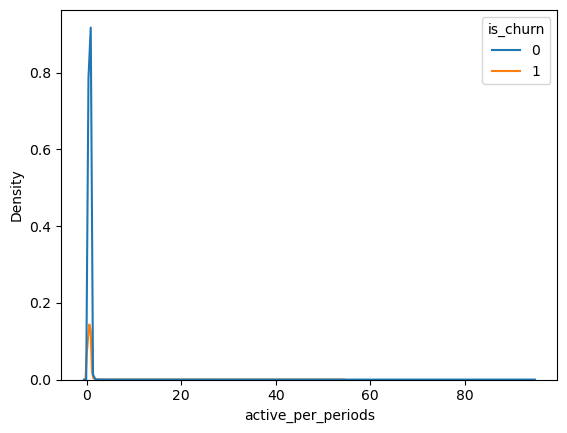

In [38]:
sns.kdeplot(data=df20230408, x='active_per_periods', hue='is_churn')

## 2023-04-10

In [24]:
transactions_df_merged = jm.add_subscribe_period(transactions_df_merged)

In [34]:
total_periods = transactions_df_merged.groupBy('msno').agg(sum('periods').alias('total_periods'))

In [73]:
user_log_avg = (user_logs_df_merged
                .groupBy('msno')
                .agg(count('*').alias('count'), avg('num_25') ,avg('num_50'), avg('num_75'),avg('num_985'),avg('num_100'),avg('num_unq'),avg('total_secs'))
                )